In [1]:
import numpy as np, pylab,sys
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit

%matplotlib inline  

In [2]:
def get_stats(log_mass,conc, bins):
    median_conc = np.empty(len(bins)-1)
    quar1_conc = np.empty(len(bins)-1)
    quar2_conc = np.empty(len(bins)-1)

    for i in range(len(bins)-1):
        mass_index = np.where((log_mass>bins[i]) & (log_mass<bins[i+1]))
        if(np.size(mass_index)>1):
            conc_index = conc[mass_index]
            print np.size(mass_index)
            median_conc[i] = np.percentile(conc_index, 50)
            quar1_conc[i] = np.percentile(conc_index, 25)
            quar2_conc[i] = np.percentile(conc_index, 75)
        else:
            median_conc[i] = median_conc[i-1]
            quar1_conc[i] = quar1_conc[i-1]
            quar2_conc[i] = quar2_conc[i-1]
                                      
    return median_conc,quar1_conc,quar2_conc

def enlarge_labels(ax,fsize):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(fsize)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(fsize)
        label_y.set_family('serif')

# Downsampling statistics

In [26]:
sample_path = '/home/forero/github/MACH/data/results/Bolshoi/downsampling/'
sample_files = glob.glob(sample_path+"*.dat")

In [27]:
def gather_data(filein):
    sample_data = np.loadtxt(filein)
    n_particles_list = np.array(list(set(sample_data[:,0])))
    #n_particles_list = n_particles_list.sort()
    n_particles_list = np.sort(n_particles_list)
    n_items = np.size(n_particles_list)

    mean_conc_mass = np.zeros(n_items)
    sigma_conc_mass = np.zeros(n_items)

    mean_conc_vel = np.zeros(n_items)
    sigma_conc_vel = np.zeros(n_items)
    for i in range(n_items):
        ii = sample_data[:,0] == n_particles_list[i]
        conc_mass = sample_data[ii,3]
        conc_vel = sample_data[ii,5]
        mean_conc_mass[i] = conc_mass.mean()
        sigma_conc_mass[i] = conc_mass.std()
        mean_conc_vel[i] = conc_vel.mean()
        sigma_conc_vel[i] = conc_vel.std()
    
    norm_m = mean_conc_mass[-1]
    norm_v = mean_conc_vel[-1]
    return n_particles_list, mean_conc_mass/norm_m, sigma_conc_mass/norm_m, mean_conc_vel/norm_v, sigma_conc_vel/norm_v
    

    
def func(x, a, b):
    return a / (1.0 + x)**b 
    #return a * x ** b


def plot_downsampling(filein):
    sample_data = np.loadtxt(filein)
    n_particles_list = np.array(list(set(sample_data[:,0])))
    #n_particles_list = n_particles_list.sort()
    n_particles_list = np.sort(n_particles_list)
    n_items = np.size(n_particles_list)

    mean_conc_mass = np.zeros(n_items)
    sigma_conc_mass = np.zeros(n_items)

    mean_conc_vel = np.zeros(n_items)
    sigma_conc_vel = np.zeros(n_items)
    for i in range(n_items):
        ii = sample_data[:,0] == n_particles_list[i]
        conc_mass = sample_data[ii,3]
        conc_vel = sample_data[ii,5]
        mean_conc_mass[i] = conc_mass.mean()
        sigma_conc_mass[i] = conc_mass.std()
        mean_conc_vel[i] = conc_vel.mean()
        sigma_conc_vel[i] = conc_vel.std()
    
    
    
    fig = plt.figure(figsize=(6.5,6.0))
    ax = plt.axes()

    enlarge_labels(ax,20)

    norm_conc_m = mean_conc_mass[-1]
    norm_conc_v = mean_conc_vel[-1]
    fraction = mean_conc_mass/norm_conc_m -1
    log_n_sample = np.linspace(2.0, 5.0, 100)
    
    popt, pcov = curve_fit(func, np.log10(n_particles_list), fraction)
    print popt
    plt.plot(10**log_n_sample, popt[0]/(1+log_n_sample)**popt[1] )
    
    a = ax.errorbar(n_particles_list*1.1, fraction,
                    yerr=sigma_conc_mass/norm_conc_m, fmt='o', label='$\mathrm{our\ method}$')
    
    
    fraction = mean_conc_vel/norm_conc_v -1

    log_n_sample = np.linspace(2.0, 5.0, 100)
    popt, pcov = curve_fit(func, np.log10(n_particles_list), fraction)
    print "vel", popt
    plt.plot(10**log_n_sample, popt[0]/(1+log_n_sample)**popt[1] )
   
    
    
    a = ax.errorbar(n_particles_list, fraction,
                    yerr=sigma_conc_vel/norm_conc_v, fmt='o', label='$\mathrm{velocity\ method}$', 
                color='red')

#plt.xlim([1,20])
    #plt.ylim([0.9,2.0])

    plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
    ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{N_{s}\ (Sample\ Particle\ Number)}$',fontsize=25)
    ax.set_ylabel(r'$(c_{\mathrm{N_{s}}} - \langle c_{\mathrm{N_{s,max}}}\rangle )/\langle c_{\mathrm{N_{s,max}}}\rangle$',fontsize=25)
#plt.savefig("conc_dens_vel.pdf")


In [28]:
conc_mass_all = np.empty((0))
conc_mass_sigma_all = np.empty((0))
conc_vel_all = np.empty((0))
conc_vel_sigma_all = np.empty((0))
n_part_all = np.empty((0))
filein = sample_files[7]
for filein in sample_files:
    a, b, c, d, e = gather_data(filein)
    conc_mass_all = np.append(conc_mass_all,b)
    conc_mass_sigma_all = np.append(conc_mass_sigma_all, c)
    conc_vel_all = np.append(conc_vel_all, d)
    conc_vel_sigma_all = np.append(conc_vel_sigma_all, e)
    n_part_all = np.append(n_part_all, a)
    #print conc_mass_all

mass [-110.6052933     7.11927941] 253.257506868 1.80837346953
vel [ 3385.39876911     7.99854704] 2065.05722831 0.485911163266


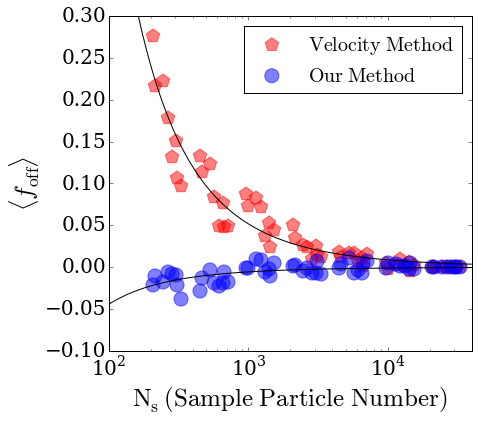

In [47]:
    
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)
log_n_sample = np.linspace(2.0, 4.6, 100)
    
popt_mass, pcov = curve_fit(func, np.log10(n_part_all), conc_mass_all-1)
print "mass", popt_mass, np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1])
plt.plot(10**log_n_sample, func(log_n_sample, popt_mass[0], popt_mass[1]), color='black')

popt_vel, pcov = curve_fit(func, np.log10(n_part_all), conc_vel_all-1)
print "vel", popt_vel, np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1])
plt.plot(10**log_n_sample, func(log_n_sample, popt_vel[0], popt_vel[1]), color='black')

plt.scatter(n_part_all, conc_vel_all-1, color='red', marker="p", s=200, alpha=0.5, label=r'$\mathrm{Velocity\ Method}$')
plt.scatter(n_part_all, conc_mass_all-1, color='blue', marker="o", s=200, alpha=0.5, label=r'$\mathrm{Our\ Method}$')
plt.xlim([1E2,4E4])
plt.ylim([-0.1, 0.3])

plt.xscale('log')
ax.set_ylabel(r'$\langle f_{\mathrm{off}}\rangle$',fontsize=25)
ax.set_xlabel('$\mathrm{N_{s}\ (Sample\ Particle\ Number)}$',fontsize=25)

ax.legend(loc=1, borderaxespad=0.5, prop={'size':20}, scatterpoints=1)
plt.savefig('../paper/avg_foff_bolshoi.pdf', bbox_inches='tight')
#plt.savefig("conc_dens_vel.pdf")

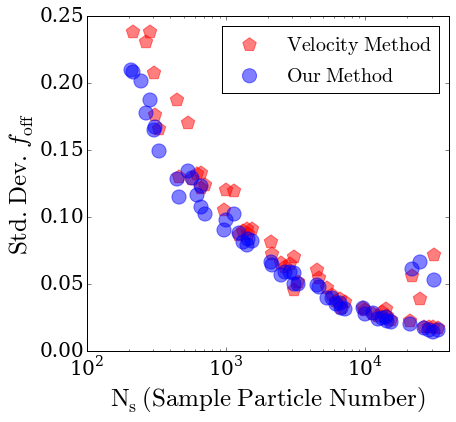

In [14]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

plt.scatter(n_part_all, conc_vel_sigma_all, color='red',  marker="p", s=200, alpha=0.5, label=r'$\mathrm{Velocity\ Method}$')
plt.scatter(n_part_all, conc_mass_sigma_all, color='blue', marker="o", s=200, alpha=0.5, label=r'$\mathrm{Our\ Method}$')

plt.xlim([1E2,4E4])
plt.ylim([0.0, 0.25])

plt.xscale('log')
ax.set_ylabel(r'$\mathrm{Std.\ Dev.}\ f_{\mathrm{off}}$',fontsize=25)
ax.set_xlabel('$\mathrm{N_{s}\ (Sample\ Particle\ Number)}$',fontsize=25)
ax.legend(loc=1, borderaxespad=0.5, prop={'size':20}, scatterpoints=1)
plt.savefig('../paper/stddev_foff_bolshoi.pdf', bbox_inches='tight')




In [18]:
#filein = sample_files[7]
#for filein in sample_files:
#    plot_downsampling(filein)

In [105]:
data_dens_bolshoi = np.loadtxt("../data/results/Bolshoi/density/results.dat")
data_vel_bolshoi = np.loadtxt("../data/results/Bolshoi/velocity/results.csv", delimiter=',')
data_mass_bolshoi = np.loadtxt("../data/results/Bolshoi/mass/results.csv", delimiter=',')

id_dens_bolshoi = np.int_(data_dens_bolshoi[:,0])
id_vel_bolshoi = np.int_(data_vel_bolshoi[:,0])
id_mass_bolshoi = np.int_(data_mass_bolshoi[:,0])



bolshoi_particle_mass = 1.35E8 # Msun/h

# velocity data
ii = np.in1d(id_vel_bolshoi,id_dens_bolshoi)
conc_bolshoi_vel = data_vel_bolshoi[:,1]
halo_mass_vel = data_vel_bolshoi[:,2] * bolshoi_particle_mass

# mass data
ii = np.in1d(id_mass_bolshoi,id_dens_bolshoi)
conc_low_bolshoi_mass = data_mass_bolshoi[:,1]
conc_bolshoi_mass = data_mass_bolshoi[:,2]
conc_up_bolshoi_mass = data_mass_bolshoi[:,3]
bolshoi_npart = data_mass_bolshoi[:,4]
halo_mass_mass = data_mass_bolshoi[:,4] * bolshoi_particle_mass


#density data

conc_bolshoi_density = data_dens_bolshoi[:,3] / data_dens_bolshoi[:,1] 
halo_mass_density = data_dens_bolshoi[:,4] * 1E10 

In [106]:
n_bins = 12
log_mass_interval = np.linspace(10.4,14.5,n_bins)

mid_log_mass_interval = 0.5*(log_mass_interval[1:] + log_mass_interval[:-1])
mid_log_mass_interval =  log_mass_interval[:-1]

conc_median = np.ones((n_bins-1,3))
conc_up = np.ones((n_bins-1,3))
conc_down = np.ones((n_bins-1,3))

conc_median[:,0], conc_down[:,0], conc_up[:,0] = get_stats(np.log10(halo_mass_density), conc_bolshoi_density, log_mass_interval)
conc_median[:,1], conc_down[:,1], conc_up[:,1] = get_stats(np.log10(halo_mass_vel), conc_bolshoi_vel, log_mass_interval)
conc_median[:,2], conc_down[:,2], conc_up[:,2] = get_stats(np.log10(halo_mass_mass), conc_bolshoi_mass, log_mass_interval)

32985
16856
7899
3705
1778
796
329
137
41
5
31930
17416
8161
3827
1833
833
340
142
44
5
31930
17416
8161
3827
1833
833
340
142
44
5


z 6.70148589771 -0.0841863798936


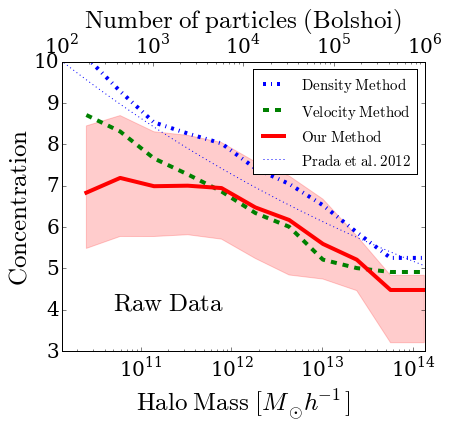

In [107]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']
for i in range(3):
    ax.plot(10**mid_log_mass_interval,conc_median[:,i],colores[i],lw=4,linestyle=estilos[i], label=origen[i])

ax.fill_between(10**mid_log_mass_interval,conc_down[:,2], conc_up[:,2], color=colores[2], alpha=0.2)

#for i in range(3):

#ax.plot(10**mid_log_mass_interval_MD,conc_median_MD[:,2],'blue',lw=4,linestyle=estilos[2])
#ax.fill_between(10**mid_log_mass_interval_MD,conc_down_MD[:,2], conc_up_MD[:,2], color='blue', alpha=0.2)
    
#datos de prada
log_mass_range = np.linspace(9.0, 15.0, 100)
conc_theory = 7.28 * (10**log_mass_range/(1.0E12))**-0.074
ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada\ et\ al.\ 2012}$', linestyle=':')

#fit
z = np.polyfit((mid_log_mass_interval[3:] - 12.0), np.log10(conc_median[3:,2]), 1)
print "z", 10**z[1], z[0]

#datos del fit
# log_mass_range = np.linspace(10.0, 15.0, 100)
# conc_theory = 10**z[1]*(10**log_mass_range/(1E12))**z[0]
# ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{nuestro}$')

min_part = 1E2
max_part = 1E6
ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
plt.xlim([min_part*bolshoi_particle_mass,max_part*bolshoi_particle_mass])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)
ax.set_ylim([3,10.0])
#ax.set_yscale('log')

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([min_part,max_part])
ax2.set_ylim([3,10.0])

ax2.set_xlabel('$\mathrm{Number\ of\ particles\ (Bolshoi)}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)
ax.text(5E10, 4, r'$\mathrm{Raw\ Data}$', fontsize=25)
plt.savefig('../paper/concentration_bolshoi.pdf', bbox_inches='tight')


[ 0.25961514  0.10947894  0.05022247  0.02469053  0.01286231  0.00703829
  0.0040177   0.00237927  0.00145513  0.00091565  0.00059098]
[-0.02403711 -0.01114566 -0.00557028 -0.00296079 -0.00165702 -0.00096886
 -0.00058822 -0.00036899 -0.0002382  -0.00015772 -0.00010682]
z 6.28987260728 -0.0597363958879


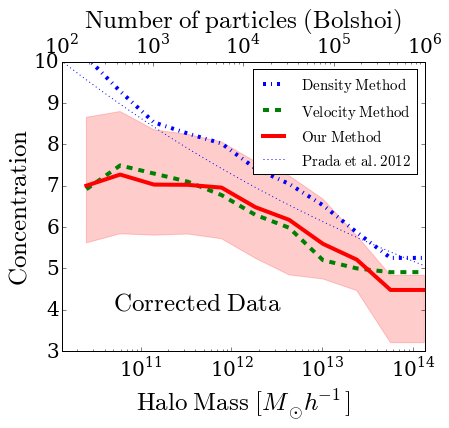

In [108]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']

mid_log_n_particle = mid_log_mass_interval - np.log10(bolshoi_particle_mass)
#density
i=0
ax.plot(10**mid_log_mass_interval,conc_median[:,i],colores[i],lw=4,linestyle=estilos[i], label=origen[i])

#velocity
i=1
f_off = func(mid_log_n_particle, popt_vel[0], popt_vel[1])
ax.plot(10**mid_log_mass_interval,conc_median[:,i]/(1.0+f_off),colores[i],lw=4,linestyle=estilos[i], label=origen[i])
print f_off

#mass
i=2
f_off = func(mid_log_n_particle, popt_mass[0], popt_mass[1])
ax.plot(10**mid_log_mass_interval,conc_median[:,i]/(1.0+f_off),colores[i],lw=4,linestyle=estilos[i], label=origen[i])
ax.fill_between(10**mid_log_mass_interval,conc_down[:,2]/(1.0+f_off), conc_up[:,2]/(1.0+f_off), color=colores[2], alpha=0.2)

print f_off

    
#datos de prada
log_mass_range = np.linspace(9.0, 15.0, 100)
conc_theory = 7.28 * (10**log_mass_range/(1.0E12))**-0.074
ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada\ et\ al.\ 2012}$', linestyle=':')

#fit
z = np.polyfit((mid_log_mass_interval[:] - 12.0), np.log10(conc_median[:,2]/(1+f_off)), 1)
print "z", 10**z[1], z[0]

#datos del fit
# log_mass_range = np.linspace(10.0, 15.0, 100)
# conc_theory = 10**z[1]*(10**log_mass_range/(1E12))**z[0]
# ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{nuestro}$')

min_part = 1E2
max_part = 1E6
ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
plt.xlim([min_part*bolshoi_particle_mass,max_part*bolshoi_particle_mass])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)
ax.set_ylim([3,10.0])
#ax.set_yscale('log')

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([min_part,max_part])
ax2.set_ylim([3,10.0])

ax2.set_xlabel('$\mathrm{Number\ of\ particles\ (Bolshoi)}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)

ax.text(5E10, 4, r'$\mathrm{Corrected\ Data}$', fontsize=25)
plt.savefig('../paper/concentration_bolshoi_corrected.pdf', bbox_inches='tight')

In [ ]:
conc_bolshoi_mass = data_mass_bolshoi[:,2]
conc_low_bolshoi_mass = data_mass_bolshoi[:,1]
conc_up_bolshoi_mass = data_mass_bolshoi[:,3]

0.00115175931081 66.6666666667


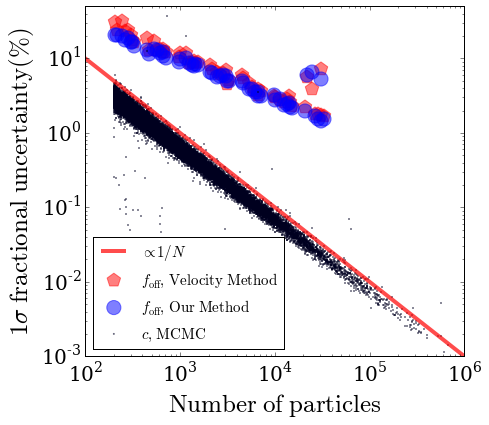

In [111]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(-1.0,60, 100)
slope = -1.0
norm = 1E3


plt.scatter(n_part_all, conc_vel_sigma_all * 100, color='red',  marker="p", s=200, alpha=0.5, 
                label=r'$f_{\rm off },\ \mathrm{Velocity\ Method}$')
plt.scatter(n_part_all, conc_mass_sigma_all * 100, color='blue', marker="o", s=200, alpha=0.5, 
                label=r'$f_{\rm off},\ \mathrm{Our\ Method}$')

#plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
#plt.scatter(conc_mass_sorted, conc_velocity_sorted,

frac = 100*(conc_up_bolshoi_mass - conc_low_bolshoi_mass)/conc_bolshoi_mass
ii = (bolshoi_npart < 1E6) & (frac > 1E-5)
plt.scatter(bolshoi_npart[ii], frac[ii],  s=1.0, alpha=0.5, label='$c,\ \mathrm{MCMC}$')

print frac.min(), frac.max()
plt.plot(x**10,norm*(x**10)**slope, color='red', linewidth=4, alpha=0.7, label='$\propto 1/N$')


plt.xlim([1E2,1E6])
plt.ylim([1E-3,50])

ax.legend(loc=3, borderaxespad=0.5, prop={'size':15}, scatterpoints=1)

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$1\sigma\ \mathrm{fractional\ uncertainty} (\%)$',fontsize=25)
ax.set_xlabel('$\mathrm{Number\ of\ particles}}$',fontsize=25)
plt.savefig("../paper/error_conc_bolshoi.pdf",bbox_inches='tight')

In [ ]:
density_filename = "../data/results/jc/MultiDark/Rvir_Mvir_fitparams_Multidark.dat"
velocity_filename = "../data/results/MDmini/velocity/results.csv"
mass_filename = "../data/results/MDmini/mass/results.csv"
centers = "../data/results/MDmini/centers.csv"

In [ ]:
data_density = np.loadtxt(density_filename)
data_velocity = np.loadtxt(velocity_filename, delimiter=",")
data_mass = np.loadtxt(mass_filename, delimiter=",")
data_centers = np.loadtxt(centers, delimiter=",")

In [ ]:
# mass here is the virial mass
mass_density = data_density[:,1]*1.0E10
conc_density = data_density[:,0]/data_density[:,2]
log_mass_density = np.log10(mass_density)

particle_mass = 8.721E9

mass_velocity = data_velocity[:,7]*particle_mass
conc_velocity = data_velocity[:,4]
log_mass_velocity = np.log10(mass_velocity)

mass_mass  = data_mass[:,8]*particle_mass
conc_mass = data_mass[:,4]
log_mass_mass = np.log10(mass_mass)


#center offset
log_mass_centers = np.log10(data_centers[:,11]*particle_mass)
delta_center = np.sqrt((data_centers[:,1] - data_centers[:,4])**2
                    + (data_centers[:,2] - data_centers[:,5])**2
                    + (data_centers[:,3] - data_centers[:,6])**2)
#delta_center = delta_center/data_velocity[:,6]

In [ ]:
fig = plt.figure()
plt.scatter(np.log10(mass_density), conc_density)
plt.xlim([12.2,15.0])
plt.ylim([0.0,50.0])

In [ ]:
n_bins = 7
log_mass_interval_MD = np.linspace(12.25,14.5,n_bins)
mid_log_mass_interval_MD = 0.5*(log_mass_interval_MD[1:] + log_mass_interval_MD[:-1])
mid_log_mass_interval_MD =  log_mass_interval_MD[:-1]

conc_median_MD = np.ones((n_bins-1,3))
conc_up_MD = np.ones((n_bins-1,3))
conc_down_MD = np.ones((n_bins-1,3))

conc_median_MD[:,0], conc_down_MD[:,0], conc_up_MD[:,0] = get_stats(log_mass_density,conc_density, log_mass_interval_MD)
conc_median_MD[:,1], conc_down_MD[:,1], conc_up_MD[:,1] = get_stats(log_mass_velocity,conc_velocity, log_mass_interval_MD)
conc_median_MD[:,2], conc_down_MD[:,2], conc_up_MD[:,2] = get_stats(log_mass_mass,conc_mass, log_mass_interval_MD)


In [ ]:
fig = plt.figure(figsize=(8.0,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']
for i in range(3):
    ax.plot(10**mid_log_mass_interval_MD,conc_median_MD[:,i],colores[i],lw=4,linestyle=estilos[i], label=origen[i])

ax.fill_between(10**mid_log_mass_interval_MD,conc_down_MD[:,2], conc_up_MD[:,2], color=colores[2], alpha=0.2)

#datos de prada
log_mass_range = np.linspace(11.0, 15.0, 100)
conc_theory = 7.28 * (10**log_mass_range/(1.0E12))**-0.074
ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada\ et\ al.\ 2012}$', linestyle=':')

#fit
z = np.polyfit((mid_log_mass_interval_MD - 12.0), np.log10(conc_median_MD[:,2]), 1)
print "z", 10**z[1], z[0]

#datos del fit
#log_mass_range = np.linspace(11.0, 15.0, 100)
#conc_theory = 10**z[1]*(10**log_mass_range/(1E12))**z[0]
#ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada et al. 2012}$')


ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
plt.xlim([1E2*particle_mass,2E4*particle_mass])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)
ax.set_ylim([2.5,8.5])

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([1E2,2E4])
ax2.set_ylim([2.5,8.5])

ax2.set_xlabel('$\mathrm{Number\ of\ particles}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)
plt.savefig("concentration.pdf")

In [ ]:
index_greater = np.where(log_mass_density>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_density[index_greater])
conc_density_sorted = conc_density[index_greater[sort_index]]

index_greater = np.where(log_mass_velocity>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_velocity[index_greater])
conc_velocity_sorted = conc_velocity[index_greater[sort_index]]

index_greater = np.where(log_mass_mass>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_mass[index_greater])
conc_mass_sorted = conc_mass[index_greater[sort_index]]

index_greater = np.where(log_mass_centers>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_centers[index_greater])
data_centers_sorted = data_centers[sort_index, :]

log_mass_sorted = log_mass_centers[sort_index]

delta_center = np.sqrt((data_centers_sorted[:,2] - data_centers_sorted[:,5])**2
                    + (data_centers_sorted[:,3] - data_centers_sorted[:,6])**2
                    + (data_centers_sorted[:,4] - data_centers_sorted[:,7])**2)
delta_center = delta_center/data_centers_sorted[:,12]

delta0 = data_centers_sorted[:,8] + data_centers_sorted[:,9] + data_centers_sorted[:,10]
lambda1 = np.amax(data_centers_sorted[:,8:11], axis=1)
lambda3 = np.amin(data_centers_sorted[:,8:11], axis=1)
lambda2 = delta0 - lambda1 - lambda3
ellipticity = (lambda1-lambda3)/(2.0 * delta0)
prolateness = (lambda1+lambda3 - 2.0*lambda2)/(2.0*delta0)
q_shape = np.sqrt((3.0*ellipticity**2 + prolateness**2))

In [ ]:
def plot_dependence(parameter, ratio, bins=7):
    bin_parameter = np.linspace(np.min(parameter),np.max(parameter),bins)
    center_parameter = 0.5*(bin_parameter[0:-1] + bin_parameter[1:])
    ratio_center, ratio_down, ratio_up = get_stats(parameter, ratio, bin_parameter)
    plt.plot(center_parameter, ratio_center, linewidth=10)
    plt.fill_between(center_parameter,ratio_down, ratio_up, alpha=0.2)

In [ ]:
plot_dependence(log_mass_sorted, ellipticity, bins=7)

In [ ]:
plot_dependence(log_mass_sorted, prolateness, bins=7)

In [ ]:
plot_dependence(log_mass_sorted, conc_density_sorted/conc_velocity_sorted, bins=7)

In [ ]:
plot_dependence(log_mass_sorted, conc_density_sorted/conc_mass_sorted, bins=7)

In [ ]:
plot_dependence(np.log10(conc_velocity_sorted), conc_velocity_sorted/conc_mass_sorted, bins=7)
10**0.6

In [ ]:
ratio = conc_density_sorted/conc_mass_sorted
plot_dependence(np.log10(conc_density_sorted), ratio, bins=7)
plot_dependence(np.log10(conc_density_sorted[delta_center>0.10]), ratio[delta_center>0.10], bins=7)

In [ ]:
ratio = conc_density_sorted/conc_mass_sorted
plot_dependence(np.log10(conc_mass_sorted), ratio, bins=7)

In [ ]:
ratio = conc_density_sorted/conc_mass_sorted
plot_dependence(log_mass_sorted, ratio, bins=7)
plot_dependence(log_mass_sorted[delta_center<0.10], ratio[delta_center<0.10], bins=7)
plot_dependence(log_mass_sorted[delta_center>0.40], ratio[delta_center>0.40], bins=7)

In [ ]:
ratio = conc_density_sorted/conc_mass_sorted
plot_dependence(log_mass_sorted, ratio, bins=7)
plot_dependence(log_mass_sorted[ellipticity<0.10], ratio[ellipticity<0.10], bins=7)
plot_dependence(log_mass_sorted[ellipticity>0.15], ratio[ellipticity>0.15], bins=7)

In [ ]:
plot_dependence(np.log10(conc_mass_sorted), conc_mass_sorted/conc_velocity_sorted, bins=7)

In [ ]:
plot_dependence(delta_center, conc_mass_sorted/conc_density_sorted, bins=7)

In [ ]:
plot_dependence(ellipticity, conc_mass_sorted/conc_density_sorted, bins=7)

In [ ]:
plot_dependence(prolateness, conc_mass_sorted/conc_density_sorted, bins=7)

In [ ]:
plot_dependence(np.log10(q_shape), conc_mass_sorted/conc_density_sorted, bins=7)

In [ ]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.scatter(conc_mass_sorted, conc_velocity_sorted, s=10, alpha=0.5)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_mass_vel.pdf")

In [ ]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.scatter(conc_mass_sorted, conc_density_sorted, s=10, alpha=0.5)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
plt.savefig("conc_mass_dens.pdf")

In [ ]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.scatter(conc_density_sorted, conc_velocity_sorted, s=10, alpha=0.5)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_dens_vel.pdf")

In [ ]:
#now comes the comparison of the mock halos

In [ ]:
density_filename = "../data/test/mock_100/newDensity/table.csv"
velocity_filename = "../data/test/mock_100/velocity/table.csv"
mass_filename = "../data/test/mock_100/newMass/table.csv"

In [ ]:
density_data = np.loadtxt(density_filename, delimiter=',')
velocity_data = np.loadtxt(velocity_filename, delimiter=',')
mass_data = np.loadtxt(mass_filename, delimiter=',')

In [ ]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(mass_data[:,2], density_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
plt.savefig("conc_mass_dens_intrinsic.pdf")

In [ ]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(density_data[:,2], velocity_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_dens_vel_intrinsic.pdf")

In [ ]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(mass_data[:,2], velocity_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_mass_vel_intrinsic.pdf")

In [ ]:
ratio = mass_data[:,2]/density_data[:,2]
plot_dependence(mass_data[:,2], ratio, bins=7)

ratio = mass_data[:,3]/density_data[:,3]
plot_dependence(mass_data[:,3], ratio, bins=7)

ratio = mass_data[:,3]/density_data[:,3]
plot_dependence(mass_data[:,3], ratio, bins=7)

In [ ]:
plt.plot(mid_log_mass_interval, conc_median[:,0])
plt.plot(mid_log_mass_interval, conc_median[:,1])
plt.plot(mid_log_mass_interval, conc_median[:,2])
print min(halo_mass_mass)/1E10

In [ ]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
#plt.scatter(conc_mass_sorted, conc_velocity_sorted,

ii = np.in1d(id_vel_bolshoi,id_dens_bolshoi)
plt.scatter(conc_bolshoi_vel[ii], conc_bolshoi_density,  s=1, alpha=0.5)

#ax.errorbar(conc_bolshoi_mass[ii], conc_bolshoi_vel[ii], 
#            xerr=[conc_bolshoi_mass[ii]-conc_low_bolshoi_mass[ii], conc_up_bolshoi_mass[ii] - conc_bolshoi_mass[ii]],
#            fmt='o', ecolor='g', capthick=2)
plt.xlim([1,100])
plt.ylim([1,100])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
plt.savefig("conc_vel_dens_bolshoi.pdf")

In [ ]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.plot(x,x*1.20, color='red', linewidth=2, alpha=0.7, linestyle='--')
#plt.scatter(conc_mass_sorted, conc_velocity_sorted,
ii = bolshoi_npart < 3E3

plt.scatter(conc_bolshoi_mass[ii], conc_bolshoi_vel[ii],  s=1, alpha=0.5)

#ax.errorbar(conc_bolshoi_mass[ii], conc_bolshoi_vel[ii], 
#            xerr=[conc_bolshoi_mass[ii]-conc_low_bolshoi_mass[ii], conc_up_bolshoi_mass[ii] - conc_bolshoi_mass[ii]],
#            fmt='o', ecolor='g', capthick=2)
plt.xlim([1,40])
plt.ylim([1,40])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_mass_vel_bolshoi.pdf")